Overview: You have some data about patients, and you want to train your model to predict whether a patient has a disease.

Steps:

 1) load the data and clean it (use pandas) and use text labels into numbers

2) split the data into train/test

3) Balance the data to prevent overfitting or underfitting: if you have more healthy cases than disease cases, random over sampler duplicates the minority data so that it doesnt create bias.
4) You train different models, try different classifiers and compare their results for the best possible prediction
5) evaluate those models. you evaluate them by checking:
1) accuracy scores= number of correct predictions/number of total predictions
2) confusion matrix: tells you exactly where your model gets things right or wrong

6) Use cross validation to make your results more reliable

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode # this library imports distributions (normal, binomial, exponential) mode computes the mode value
from sklearn.preprocessing import LabelEncoder # converts text labels into numbers
from sklearn.model_selection import train_test_split, cross_val_score # training testing and cv to automatically evaluate model multiple times
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold # stratified is keeping the same proportions



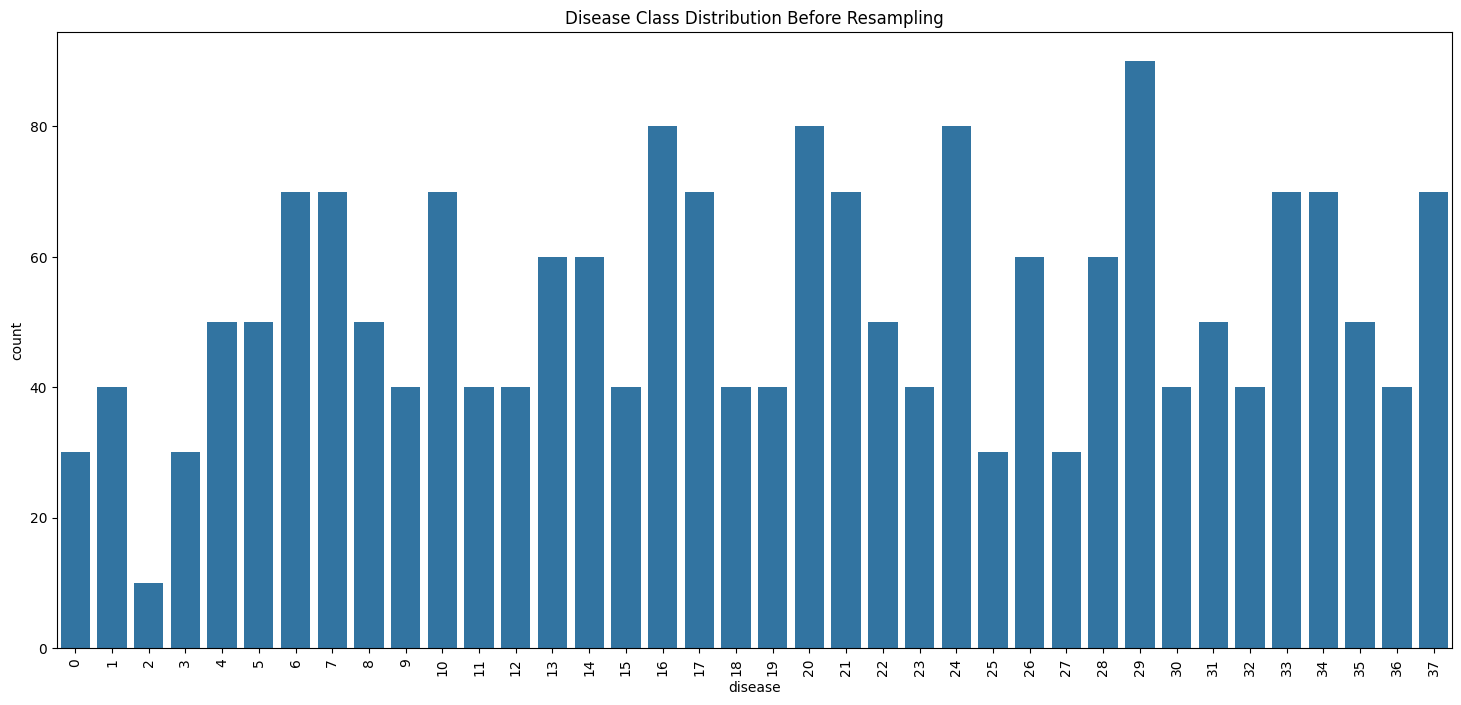

Resampled Class Distribution:
 disease
29    90
20    90
16    90
24    90
7     90
17    90
34    90
10    90
37    90
6     90
33    90
21    90
26    90
13    90
28    90
14    90
8     90
31    90
35    90
22    90
5     90
4     90
18    90
23    90
1     90
12    90
30    90
32    90
11    90
9     90
36    90
15    90
19    90
27    90
3     90
25    90
0     90
2     90
Name: count, dtype: int64


In [61]:
data = pd.read_csv('improved_disease_dataset.csv')
encoder = LabelEncoder()
data['disease'] = encoder.fit_transform(data['disease'])
data.head()
X= data.iloc[:,:-1] # last column is what you want to predict so we dont use that
y= data.iloc[:,-1]
plt.figure(figsize=(18,8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
plt.show() # the bar graph helps see if the data is balanced (some diseases more common than others)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Resampled Class Distribution:\n", pd.Series(y_resampled).value_counts())


✅ Encode any text columns (like “gender”).
✅ Make sure your data is clean.
✅ Train and cross-validate two models (Decision Tree and Random Forest).
✅ Measure their accuracy in a fair, stratified way.



In [62]:
if 'gender' in X_resampled.columns:
    le = LabelEncoder()
    X_resampled['gender'] = le.fit_transform(X_resampled['gender'])

X_resampled = X_resampled.fillna(0)

if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()
# 1) Keep only top N most common diseases
N = 10   # for example, keep only 10 diseases
top_classes = pd.Series(y_resampled).value_counts().index[:N]

# Filter rows where y_resampled is in top_classes
mask = pd.Series(y_resampled).isin(top_classes)
X_resampled = X_resampled.loc[mask]
y_resampled = pd.Series(y_resampled).loc[mask]

# 2) Randomly sample 20% of the remaining data
X_resampled = X_resampled.sample(frac=0.2, random_state=42)
y_resampled = y_resampled.loc[X_resampled.index]

# 3) (Optional) Flatten labels in case they become a Series
y_resampled = y_resampled.values.ravel()


models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

cv_scoring = 'accuracy'  # you can also use 'f1_weighted', 'roc_auc_ovr' for multi-class
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model,
            X_resampled,
            y_resampled,
            cv=stratified_kfold,
            scoring=cv_scoring,
            n_jobs=-1,
            error_score='raise'
        )
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Scores: {scores}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
    except Exception as e:
        print("=" * 50)
        print(f"Model: {model_name} failed with error:")
        print(e)

Model: Decision Tree
Scores: [0.44444444 0.55555556 0.55555556 0.5        0.52777778]
Mean Accuracy: 0.5167
Model: Random Forest
Scores: [0.61111111 0.61111111 0.61111111 0.63888889 0.47222222]
Mean Accuracy: 0.5889


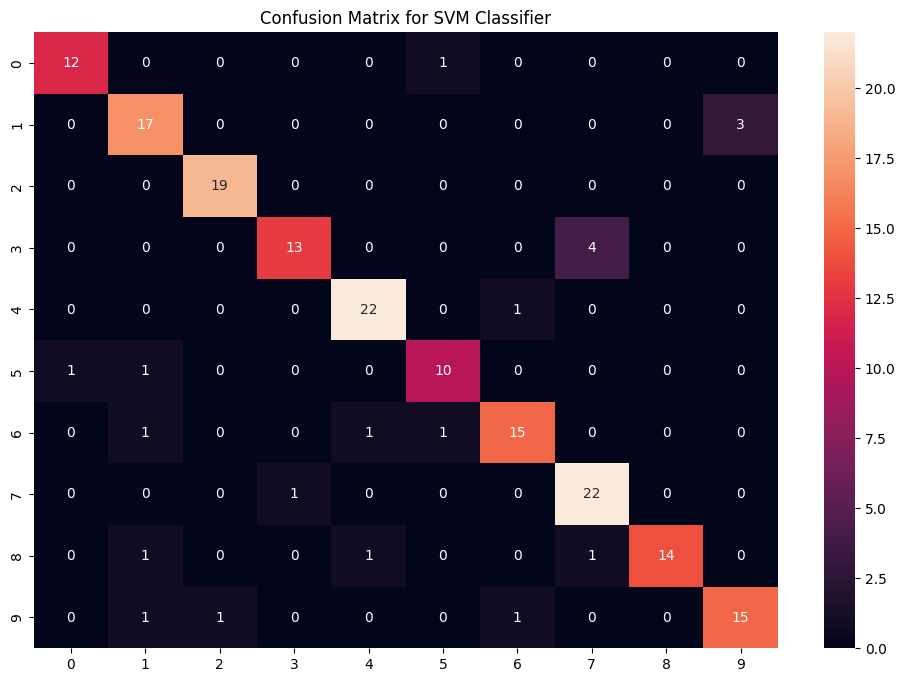

SVM Accuracy: 88.33%


In [63]:
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)
svm_preds = svm_model.predict(X_resampled)

cf_matrix_svm = confusion_matrix(y_resampled, svm_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_svm, annot=True, fmt="d")
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

print(f"SVM Accuracy: {accuracy_score(y_resampled, svm_preds) * 100:.2f}%")

38x38 matrix because you have 38 disease categories
rows are actual labels, columns are predicted labels
each cell is how many  samples of class i were predicted as class j

In [64]:
data.shape

(2000, 11)

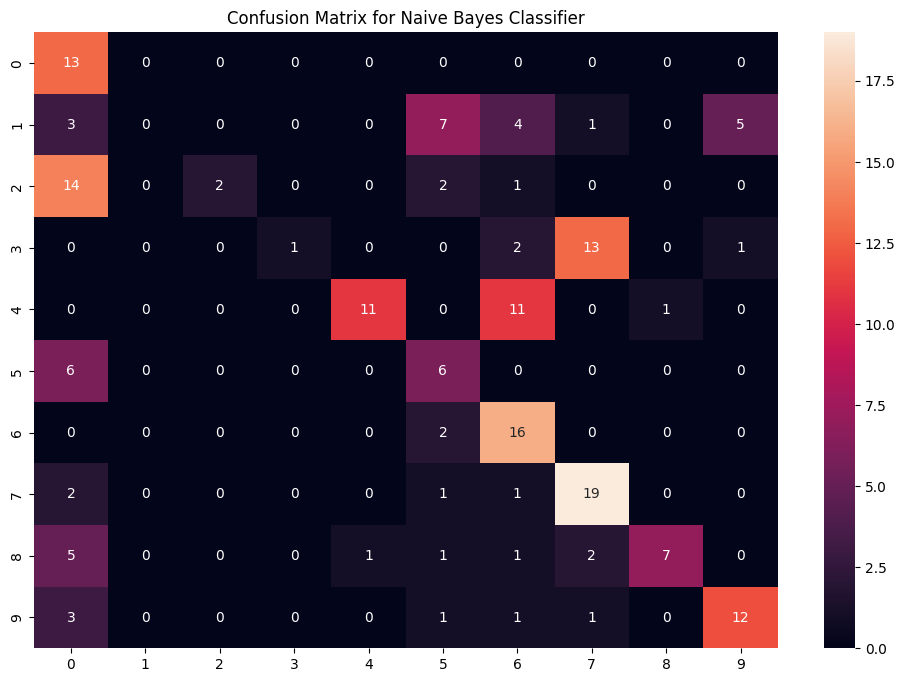

Naive Bayes Accuracy: 48.33%


In [65]:
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
nb_preds = nb_model.predict(X_resampled)

cf_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_nb, annot=True, fmt="d")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print(f"Naive Bayes Accuracy: {accuracy_score(y_resampled, nb_preds) * 100:.2f}%")

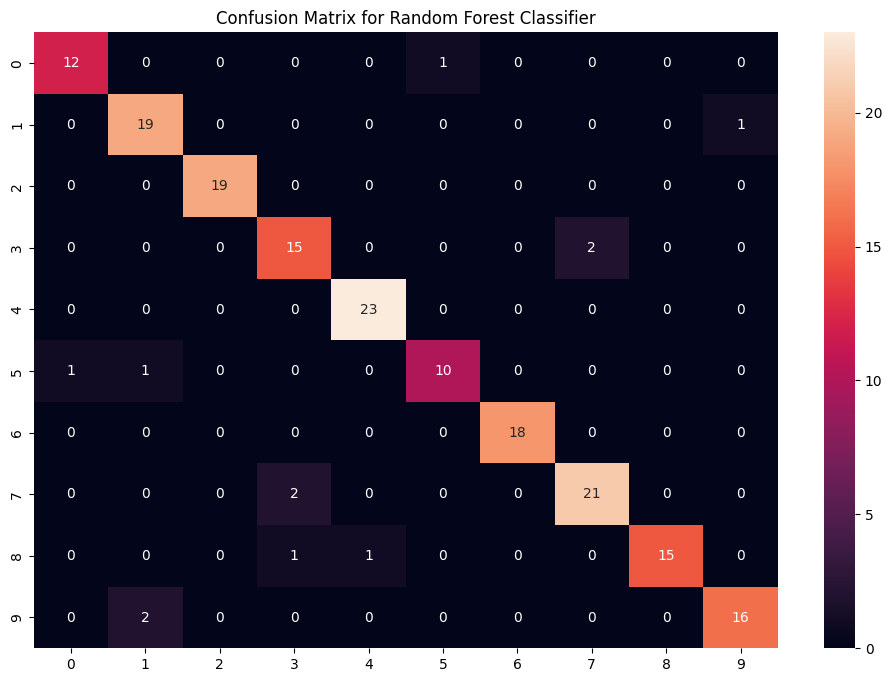

Random Forest Accuracy: 93.33%


In [66]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
rf_preds = rf_model.predict(X_resampled)

cf_matrix_rf = confusion_matrix(y_resampled, rf_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_rf, annot=True, fmt="d")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

print(f"Random Forest Accuracy: {accuracy_score(y_resampled, rf_preds) * 100:.2f}%")

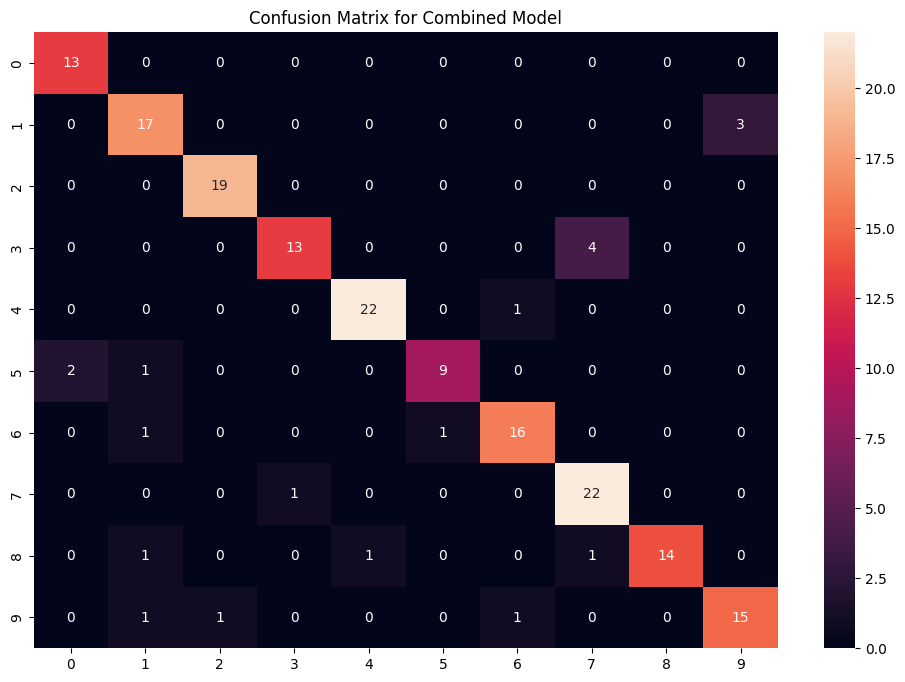

Combined Model Accuracy: 88.89%


In [67]:
from statistics import mode

final_preds = [mode([i, j, k]) for i, j, k in zip(svm_preds, nb_preds, rf_preds)]

cf_matrix_combined = confusion_matrix(y_resampled, final_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_combined, annot=True, fmt="d")
plt.title("Confusion Matrix for Combined Model")
plt.show()

print(f"Combined Model Accuracy: {accuracy_score(y_resampled, final_preds) * 100:.2f}%")

In [69]:
symptoms = X.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

def predict_disease(input_symptoms):
    input_symptoms = input_symptoms.split(",")
    input_data = [0] * len(symptom_index)

    for symptom in input_symptoms:
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1

    input_data = np.array(input_data).reshape(1, -1)

    rf_pred = encoder.classes_[rf_model.predict(input_data)[0]]
    nb_pred = encoder.classes_[nb_model.predict(input_data)[0]]
    svm_pred = encoder.classes_[svm_model.predict(input_data)[0]]

    final_pred = mode([rf_pred, nb_pred, svm_pred])

    return {
        "Random Forest Prediction": rf_pred,
        "Naive Bayes Prediction": nb_pred,
        "SVM Prediction": svm_pred,
        "Final Prediction": final_pred
    }
new_data = [[...]]  # your input row as a list

print(predict_disease("Itching,Skin Rash,Nodal Skin Eruptions"))

{'Random Forest Prediction': 'Dimorphic hemorrhoids(piles)', 'Naive Bayes Prediction': 'Impetigo', 'SVM Prediction': 'Impetigo', 'Final Prediction': 'Impetigo'}
